<a href="https://colab.research.google.com/github/RMhanovernorwichschools/neural_network_prac/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This one is for creating a model which predicts a value/values from a set of input variables (especially where the relationship is present but not the result of any obvious mathematic function)

In [3]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
            #would know these from creating data oneself. they are assigned left to right.
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
            #see pandas for more info on how to do this for own data

dataset = raw_dataset.copy()
dataset.tail() #shows end of dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
#removes all inapplicable/improperly formatted data
dataset = dataset.dropna()

#this is b/c origin represents classes/categories (countries, here) and not actual values 1 to 3, so it should be converted into multiple columns.
origin = dataset.pop('Origin')         #"origin" is columns resulting from subject of dataset.pop() which is "Origin"
dataset['USA'] = (origin == 1)*1.0     #first column in set of "origin" is labelled "USA" and = 1.0 when the value in "Origin" = 1
dataset['Europe'] = (origin == 2)*1.0  #second column (b/c specified second) has "Europe" label and = 1.0 when "Origin" = 2
dataset['Japan'] = (origin == 3)*1.0   #third labelled "japan" w/ 1.0 when "Origin" = 3
dataset.tail() #shows how this changes the dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


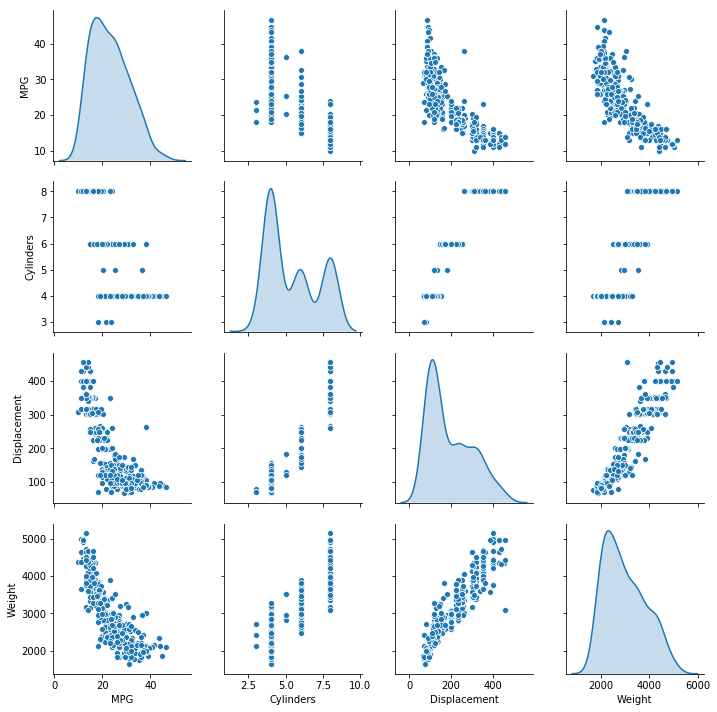

In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0) #just takes 80% of the total data, no randomness involved
test_dataset = dataset.drop(train_dataset.index)        #takes all of total data except for train_dataset

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")  #take a look at the data

In [15]:
train_stats = train_dataset.describe() #mean, std dev, etc.
train_stats.pop("MPG")                 #pop command removes column
train_stats = train_stats.transpose()  #reverses columns and rows
train_stats  #displays resulting information (which is desc of each data column w/ columns being info type (median/etc.))

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
#since MPG is what the program is trying to predict, it is the desired output for each collection of variables. I'll compile it with
train_labels = train_dataset.pop('MPG') #separates out 'MPG' column and saves it in train_labels
test_labels = test_dataset.pop('MPG')   #does the same for test data

#also important (improves efficiency) to normalize input variables so they're more balanced
all_stats = dataset.describe()
all_stats.pop('MPG')
all_stats = all_stats.transpose()

def norm(x):
  return (x - all_stats['mean']) / all_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [17]:
#building the model (will make two, so defining a function here for efficiency)
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]), #shape is 1D and according to keys (column names) of the dataset
                                                                                      #because inputs are variables according to those columns
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1) #note no activation b/c we just want the specific value it outputs
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)  #type of optimizer from keras (if more detail desired, will need to search)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error']) #checks how far off with two parameters
  return model

model1 = build_model()
model1.summary() #taking a closer look at these layers

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]        #takes first ten inputs of training data as an example
example_result = model1.predict(example_batch) #has model (untrained) predict the MPGs (outputs)
example_result #this displays and confirms that output is in desired format

array([[ 0.00650685],
       [ 0.17507188],
       [-0.40224558],
       [ 0.13190407],
       [ 0.57516104],
       [ 0.01835787],
       [ 0.5648756 ],
       [ 0.185242  ],
       [-0.03431341],
       [ 0.39647287]], dtype=float32)

In [20]:
# Display training progress by printing a single dot for each completed epoch 
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

#trains model for 1000 epochs and records training as "history", using "callbacks=" to make use of single dot class above
history = model1.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [21]:
hist = pd.DataFrame(history.history) #makes a dataframe from the history (this is pd.DataFrame([recorded_training_name].history))
hist['epoch'] = history.epoch #adds a column showing the epoch number
hist.tail() #displays the end of the training

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.669264,0.994676,2.669264,8.585380,2.274193,8.585381,995
996,2.605271,0.965926,2.605271,7.938008,2.204546,7.938008,996
997,2.624599,1.009685,2.624599,8.086051,2.199974,8.086051,997
998,2.849366,1.031874,2.849366,8.246766,2.195008,8.246766,998
999,2.422778,0.961220,2.422778,8.117307,2.199289,8.117307,999


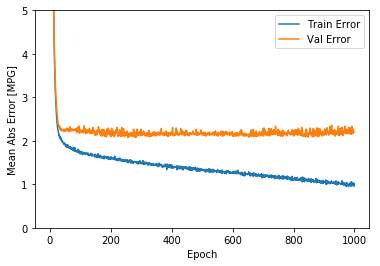

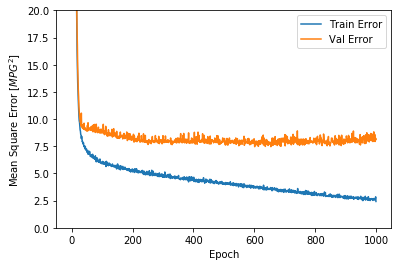

In [22]:
def plot_history(history):                #function b/c it'll be done again
  hist = pd.DataFrame(history.history) #makes training history into dataframe
  hist['epoch'] = history.epoch        #adds 'epoch' column
  
  plt.figure()
  plt.xlabel('Epoch')                     #labels x-axis as 'Epoch'
  plt.ylabel('Mean Abs Error [MPG]')      #labels y-axis
  plt.plot(hist['epoch'], hist['mean_absolute_error'], #plots (epoch,abs_error) as (x,y ) with label
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])  #limits display of y-axis
  plt.legend()
  
  plt.figure() #creates second graph for mean_squared_error
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history) #does the function above (showing graphs for the history training data) with the training just completed


...................................................................

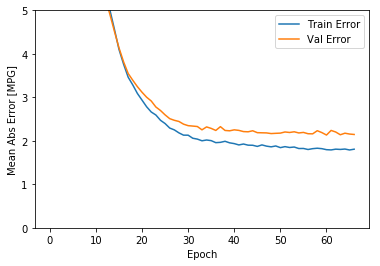

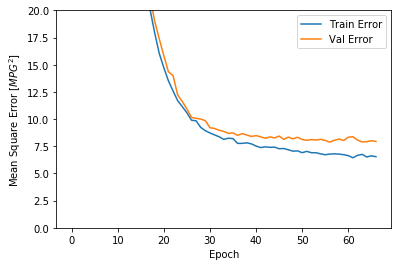

In [23]:
#since traing clearly stops being useful at a certain point, we should instruct the model to stop once it reaches that point
model2 = build_model()

# The patience parameter is the amount of epochs to check for improvement (higher number = more leniency)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  #when val_loss has been increasing/staying same for 10 epochs, stop

history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()]) #add to trainingg session as a callback to use

plot_history(history) #show the graphs for these rounds, with early_stop

In [26]:
#show how useful it would actually be by applying to test_data (evaluate)
loss, mae, mse = model2.evaluate(normed_test_data, test_labels, verbose=0) #format of (input, intended_output, verbose)
#evaluate returns a list of loss, mean_absolute_error, and mean_squared error (loss and metrics) so save them accordingly

print("Testing set Mean Abs Error: {0} MPG".format(mae))

Testing set Mean Abs Error: 1.859485387802124 MPG


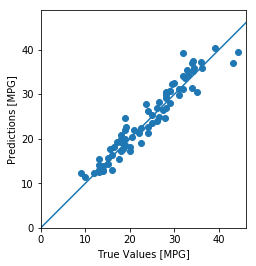

In [33]:
#to illustrate this difference graphically,
test_predictions = model2.predict(normed_test_data).flatten() #makes 1 column/many row into 1 row (1D array)

plt.scatter(test_labels, test_predictions) #plots true values as x against predicted as y
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square') #adjusting axes for display
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100]) #also plots a line from (-100,-100) to (100,100) (but doesn't show to 100 b/c axes are fixed)

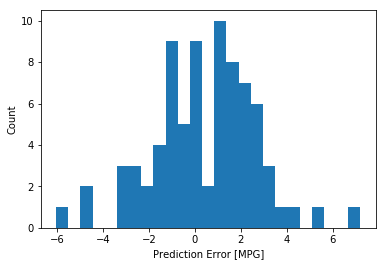

In [34]:
#error histogram
error = test_predictions - test_labels #calculates error in terms of difference and saves as array
plt.hist(error, bins = 25)             #shows histogram of all errors, separated into 25 columns
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

plt.show()

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.